In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

test_dataset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 58.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.17MB/s]


In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, 400)
        self.fc3 = nn.Linear(400, 28*28)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [4]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        recon_x, x, reduction='sum'
    )
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(latent_dim=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [6]:
epochs = 10
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for data, _ in train_loader:
        data = data.view(-1, 28*28).to(device)
        optimizer.zero_grad()

        recon, mu, logvar = model(data)
        loss = vae_loss(recon, data, mu, logvar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 165.2949
Epoch [2/10], Loss: 122.2099
Epoch [3/10], Loss: 115.1883
Epoch [4/10], Loss: 112.0781
Epoch [5/10], Loss: 110.2219
Epoch [6/10], Loss: 108.9847
Epoch [7/10], Loss: 108.1451
Epoch [8/10], Loss: 107.4575
Epoch [9/10], Loss: 106.8697
Epoch [10/10], Loss: 106.4879


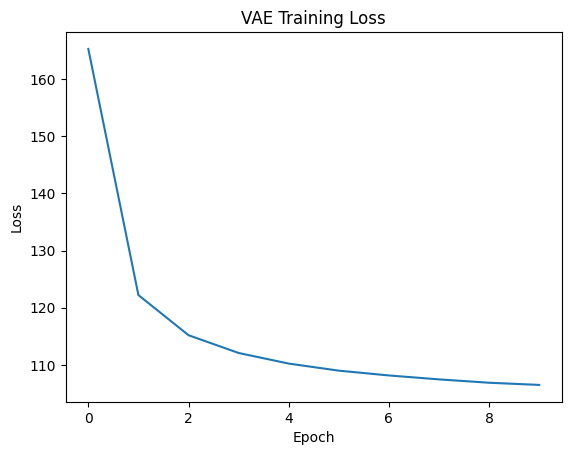

In [7]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Loss")
plt.show()


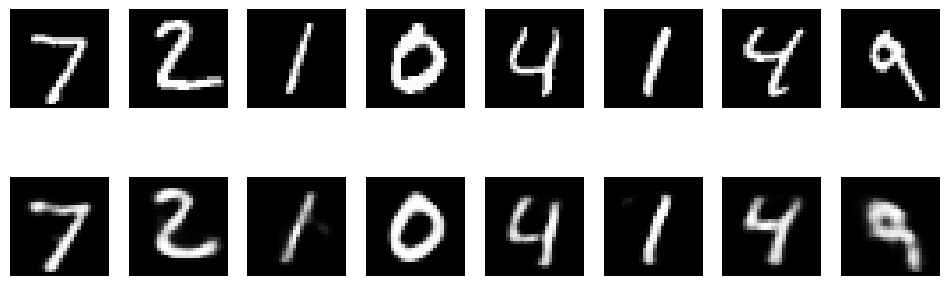

In [8]:
model.eval()
data, _ = next(iter(test_loader))
data = data.view(-1, 28*28).to(device)

with torch.no_grad():
    recon, _, _ = model(data)

# Plot original vs reconstructed
n = 8
plt.figure(figsize=(12, 4))

for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(data[i].cpu().view(28,28), cmap='gray')
    plt.axis('off')

    plt.subplot(2, n, i+1+n)
    plt.imshow(recon[i].cpu().view(28,28), cmap='gray')
    plt.axis('off')

plt.show()


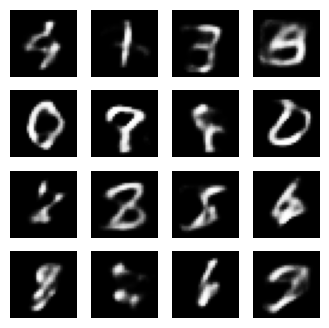

In [9]:
with torch.no_grad():
    z = torch.randn(16, 20).to(device)
    samples = model.decode(z)

plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(samples[i].cpu().view(28,28), cmap='gray')
    plt.axis('off')
plt.show()
